In [36]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

In [48]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', str(input_text))
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', str(input_text))
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)    
    
    def remove_digits(self, input_text):
        return re.sub('\d+', '', str(input_text))
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('german')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [27]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', str(x))) 
        count_data = X.apply(lambda x: self.count_regex(r'Data\w+', str(x)))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', str(x)))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', str(x)))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', str(x)))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', str(x)))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        #count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_data': count_data
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                          })
        
        return df


In [5]:
#Import the Datasets Austrian Newspaper
krone = pd.read_csv("../data/raw/newspapers/Articles_Krone.csv",encoding='windows-1254',error_bad_lines = False, sep = ";")
standard = pd.read_csv("../data/raw/newspapers/Articles_Standard.csv",encoding='windows-1254',error_bad_lines = False, sep = ";")
kurier = pd.read_csv("../data/raw/newspapers/Articles_Kurier.csv",encoding='windows-1254',error_bad_lines = False, sep = ";")

In [21]:
#Import the Datasets Swiss Newspaper
blick = pd.read_csv("../data/raw/newspapers/Articles_Blick.csv",encoding='windows-1254',error_bad_lines = False, sep = ";")
Zwanzig_min = pd.read_csv("../data/raw/newspapers/Articles_20Min.csv",encoding='windows-1254',error_bad_lines = False, sep = ";")
nzz = pd.read_csv("../data/raw/newspapers/Articles_NeueZZ.csv",encoding='windows-1254',error_bad_lines = False, sep = ";")

In [22]:
#Import the Datasets German Newspaper
bild = pd.read_csv("../data/raw/newspapers/Articles_Bild.csv",encoding='windows-1254',error_bad_lines = False, sep = ";")
sz = pd.read_csv("../data/raw/newspapers/Articles_SZ.csv",encoding='windows-1254',error_bad_lines = False, sep = ";")
faz = pd.read_csv("../data/raw/newspapers/Articles_FAZ.csv",encoding='windows-1254',error_bad_lines = False, sep = ";")

In [29]:
# Count Words per Article
tc = TextCounts()
df_eda_krone = tc.fit_transform(krone.Text)
df_eda_standard = tc.fit_transform(standard.Text)
df_eda_kurier = tc.fit_transform(kurier.Text)

df_eda_blick = tc.fit_transform(blick.Text)
df_eda_20min = tc.fit_transform(Zwanzig_min.Text)
df_eda_nzz = tc.fit_transform(nzz.Text)

df_eda_bild = tc.fit_transform(bild.Text)
df_eda_sz = tc.fit_transform(sz.Text)
df_eda_faz = tc.fit_transform(faz.Text)


In [30]:
# Add new columns to the newspaper dataframes Austria
krone["count_words"] = df_eda_krone["count_words"]
krone["count_data"] = df_eda_krone["count_data"]
krone["count_capital_words"] = df_eda_krone["count_capital_words"]

standard["count_words"] = df_eda_standard["count_words"]
standard["count_data"] = df_eda_standard["count_data"]
standard["count_capital_words"] = df_eda_standard["count_capital_words"]

kurier["count_words"] = df_eda_kurier["count_words"]
kurier["count_data"] = df_eda_kurier["count_data"]
kurier["count_capital_words"] = df_eda_kurier["count_capital_words"]

In [31]:
# Add new columns to the newspaper dataframes Switzerland
blick["count_words"] = df_eda_blick["count_words"]
blick["count_data"] = df_eda_blick["count_data"]
blick["count_capital_words"] = df_eda_blick["count_capital_words"]

Zwanzig_min["count_words"] = df_eda_20min["count_words"]
Zwanzig_min["count_data"] = df_eda_20min["count_data"]
Zwanzig_min["count_capital_words"] = df_eda_20min["count_capital_words"]

nzz["count_words"] = df_eda_nzz["count_words"]
nzz["count_data"] = df_eda_nzz["count_data"]
nzz["count_capital_words"] = df_eda_nzz["count_capital_words"]

In [32]:
# Add new columns to the newspaper dataframes Germany
bild["count_words"] = df_eda_bild["count_words"]
bild["count_data"] = df_eda_bild["count_data"]
bild["count_capital_words"] = df_eda_bild["count_capital_words"]

sz["count_words"] = df_eda_sz["count_words"]
sz["count_data"] = df_eda_sz["count_data"]
sz["count_capital_words"] = df_eda_sz["count_capital_words"]

faz["count_words"] = df_eda_faz["count_words"]
faz["count_data"] = df_eda_faz["count_data"]
faz["count_capital_words"] = df_eda_faz["count_capital_words"]

In [50]:
import nltk
nltk.download("stopwords")

ct = CleanText()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/retoheller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
# Clean the Texts
sr_clean_krone = ct.fit_transform(krone.Text)
sr_clean_standard = ct.fit_transform(standard.Text)
sr_clean_kurier = ct.fit_transform(kurier.Text)

sr_clean_blick = ct.fit_transform(blick.Text)
sr_clean_20min = ct.fit_transform(Zwanzig_min.Text)
sr_clean_nzz = ct.fit_transform(nzz.Text)

sr_clean_bild = ct.fit_transform(bild.Text)
sr_clean_sz = ct.fit_transform(sz.Text)
sr_clean_faz = ct.fit_transform(faz.Text)

In [53]:
# Add cleaned Text Austria
krone["cleaned_text"] = sr_clean_krone
standard["cleaned_text"] = sr_clean_standard
kurier["cleaned_text"] = sr_clean_kurier

In [54]:
# Add cleaned Text Switzerland
blick["cleaned_text"] = sr_clean_blick
Zwanzig_min["cleaned_text"] = sr_clean_20min
nzz["cleaned_text"] = sr_clean_nzz

In [55]:
# Add cleaned Text Germany
bild["cleaned_text"] = sr_clean_bild
sz["cleaned_text"] = sr_clean_sz
faz["cleaned_text"] = sr_clean_faz

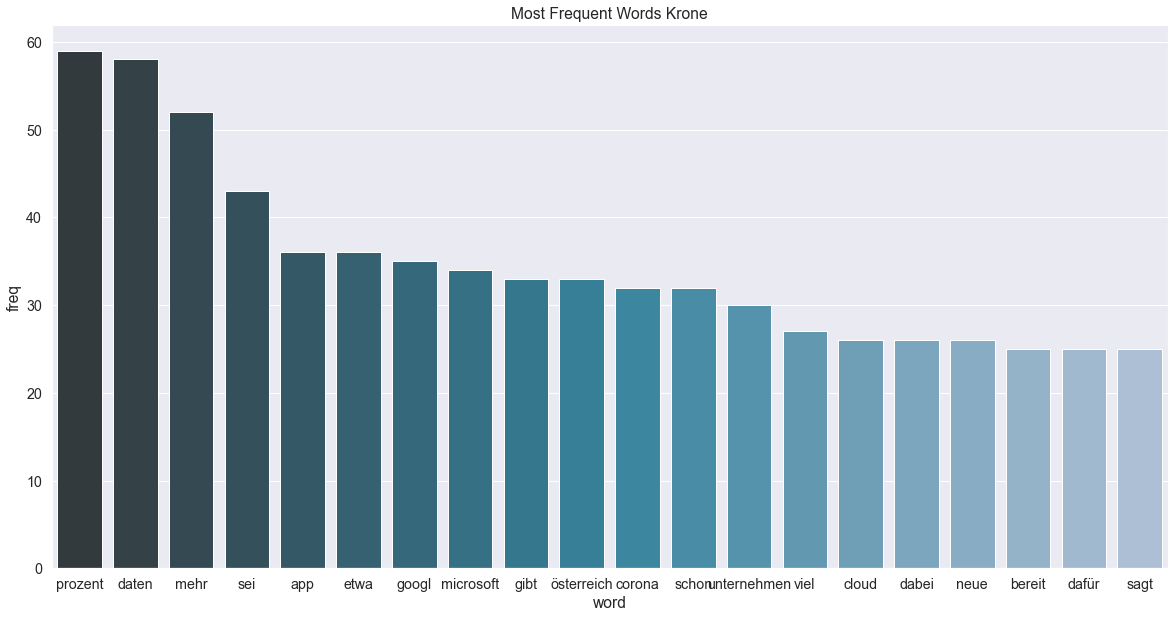

In [61]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean_krone)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.title("Most Frequent Words Krone")
plt.show();

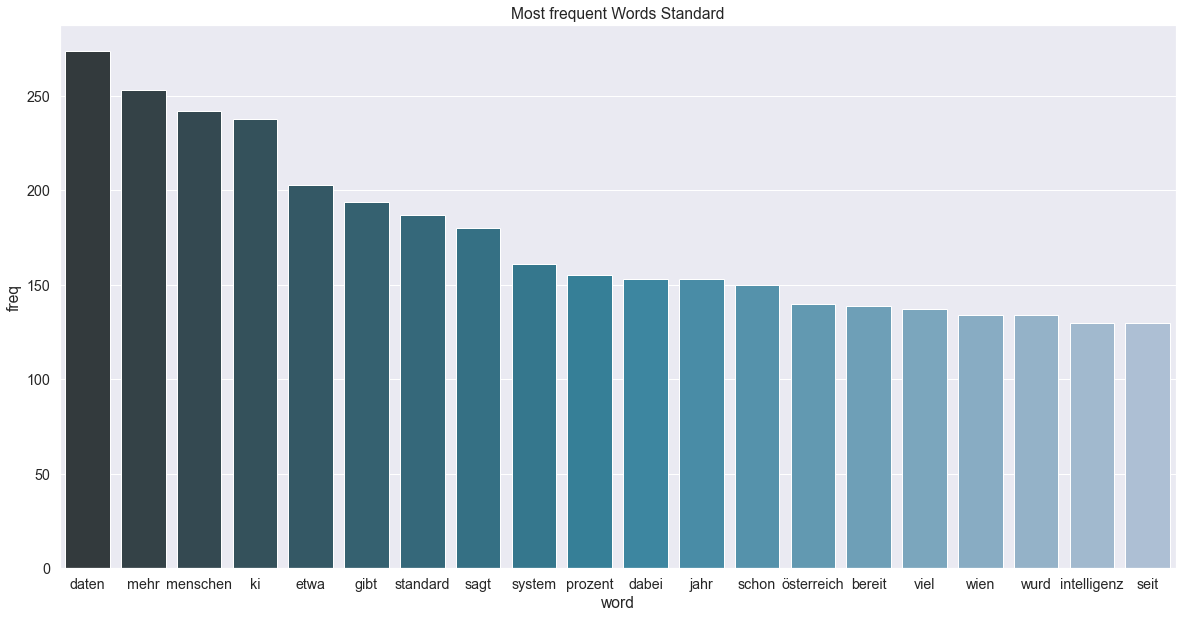

In [62]:
bow = cv.fit_transform(sr_clean_standard)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.title("Most Frequent Words Standard")
plt.show();

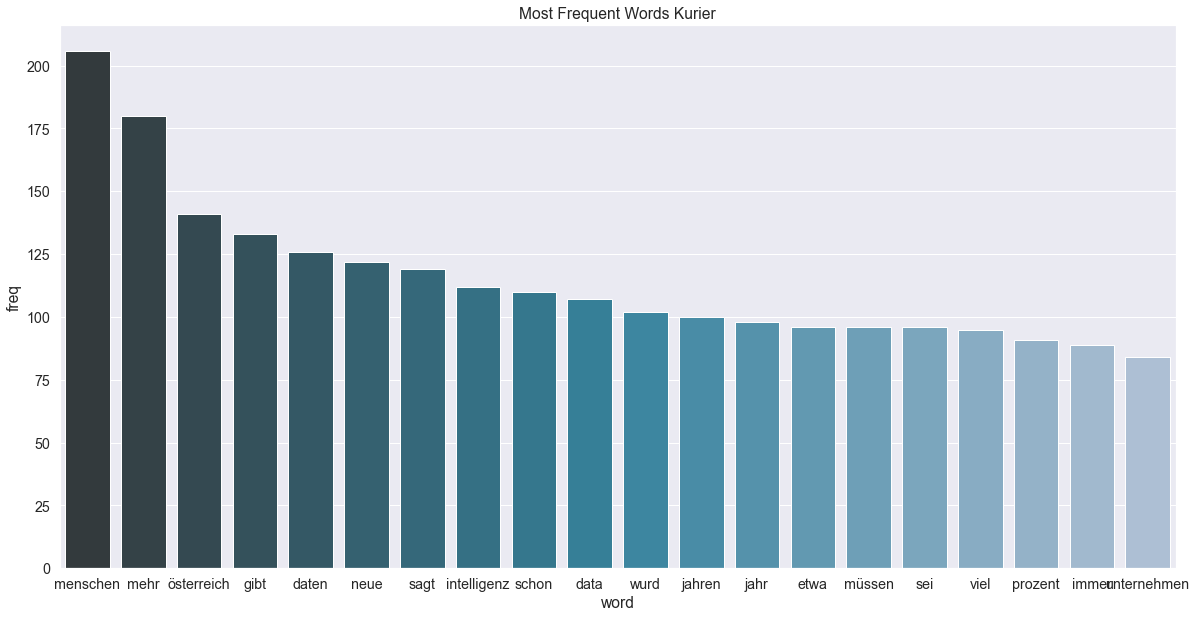

In [63]:
bow = cv.fit_transform(sr_clean_kurier)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.title("Most Frequent Words Kurier")
plt.show();

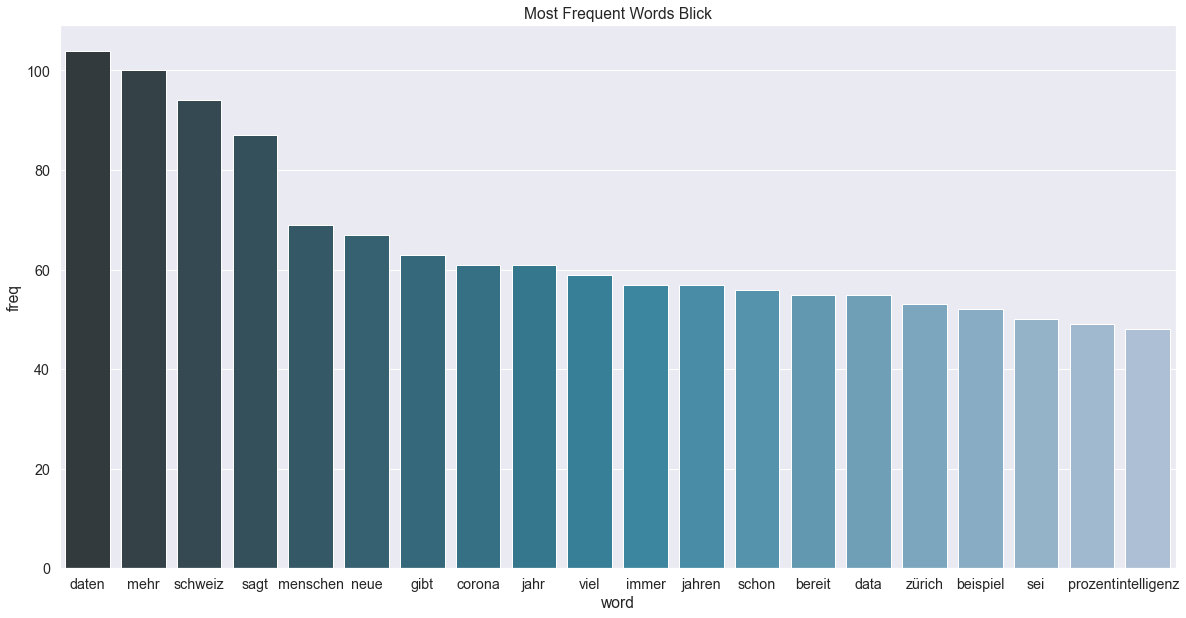

In [64]:
bow = cv.fit_transform(sr_clean_blick)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.title("Most Frequent Words Blick")
plt.show();

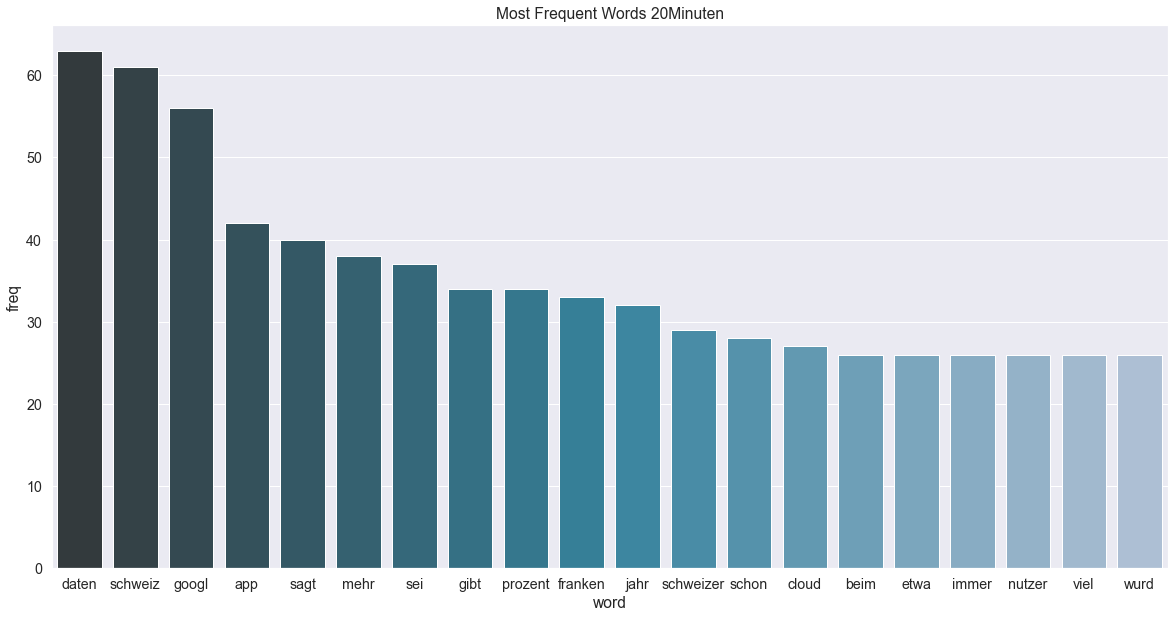

In [65]:
bow = cv.fit_transform(sr_clean_20min)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.title("Most Frequent Words 20Minuten")
plt.show();

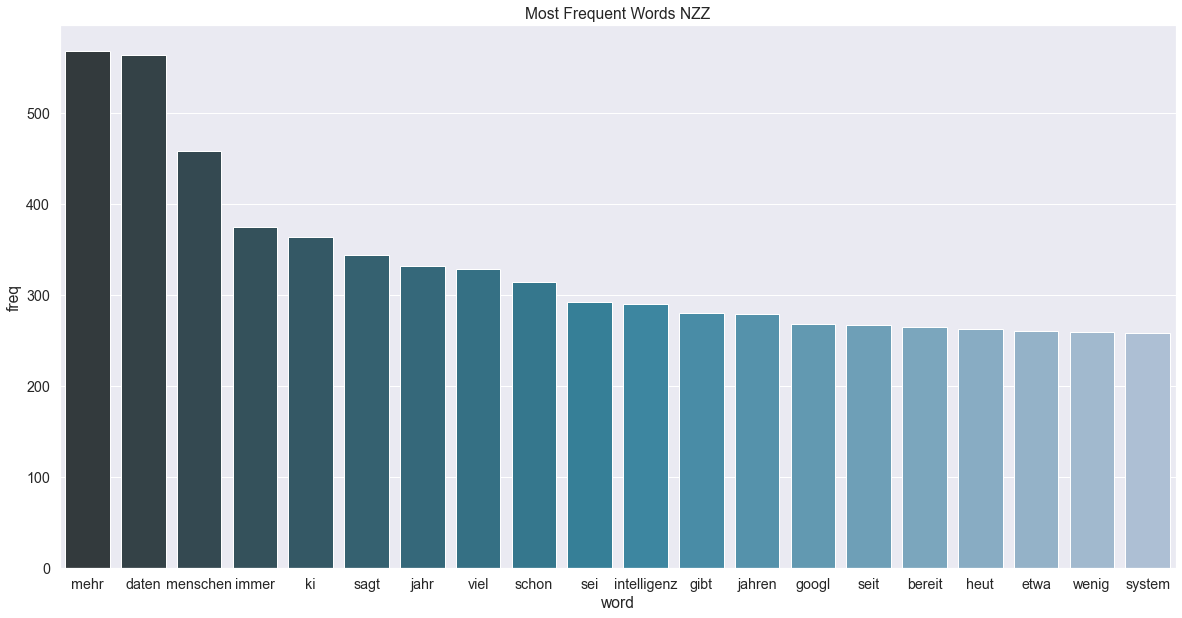

In [66]:
bow = cv.fit_transform(sr_clean_nzz)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.title("Most Frequent Words NZZ")
plt.show();

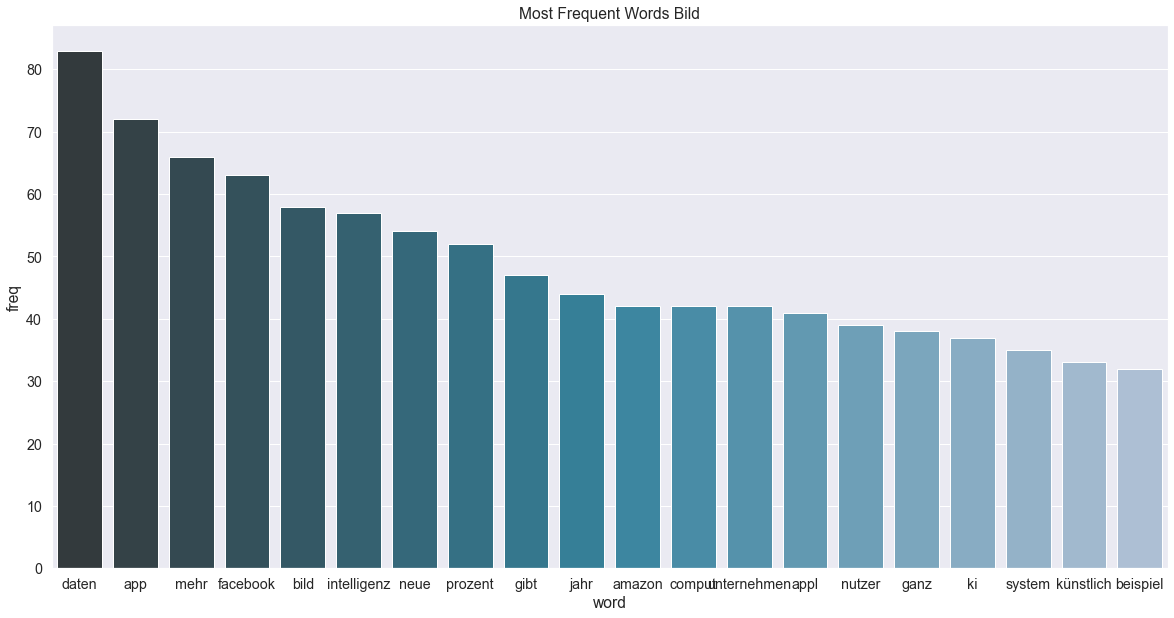

In [67]:
bow = cv.fit_transform(sr_clean_bild)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.title("Most Frequent Words Bild")
plt.show();

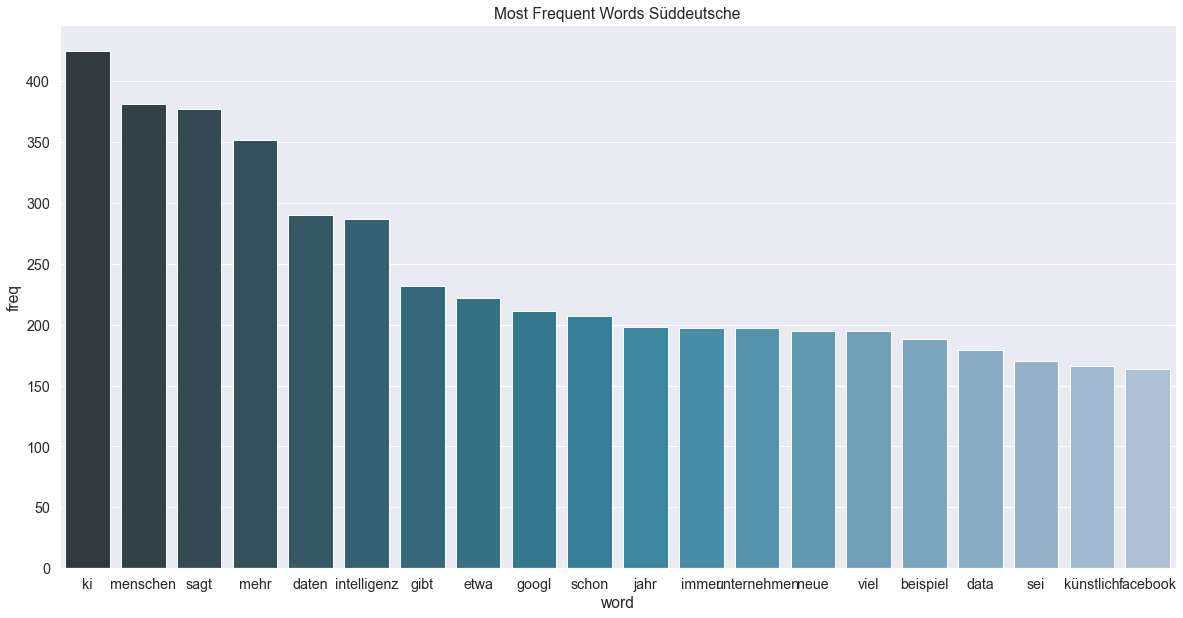

In [68]:
bow = cv.fit_transform(sr_clean_sz)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.title("Most Frequent Words Süddeutsche")
plt.show();

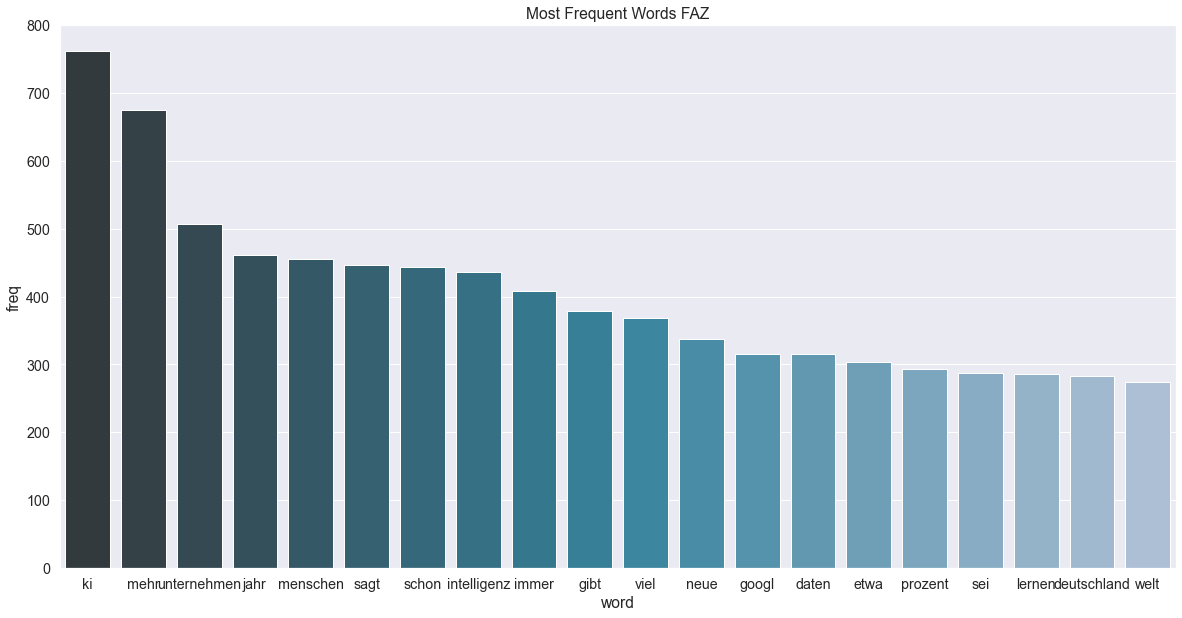

In [69]:
bow = cv.fit_transform(sr_clean_faz)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.title("Most Frequent Words FAZ")
plt.show();